# Funktionen Piringer Modell 

In [35]:
def get_material_data(material):
    # Datenbankabfrage hier noch erweiterbaR
    # material_parameter = worst case
    material_parameters = {
        "LDPE": {"A_Pt": 11.7, "tau": 0},
        # "LDPE": {"A_Pt": 11.5, "tau": 0}, #  von AKTS
        "HDPE": {"A_Pt": 13.2, "tau": 1577},
        # "HDPE": {"A_Pt": 11.9, "tau": 1577}, # für Validierung
        "LLDPE": {"A_Pt": 11.5, "tau": 0},
        "LLDPE": {"A_Pt": 9.8, "tau": 0}, # für Validierung
        "PP": {"A_Pt": 12.4, "tau": 1577},
        "PET": {"A_Pt": 6.35, "tau": 1577},
        "PS": {"A_Pt": -0.7, "tau": 0},
        "PEN": {"A_Pt": 3.7, "tau": 1577},
        "HIPS": {"A_Pt": 0.1, "tau": 0}
    }

    material_parameters_best_case = {
        "LDPE": {"A_Pt": 10.0, "tau": 0},
        "HDPE": {"A_Pt": 10.0, "tau": 1577},
        # "LLDPE": {"A_Pt": 11.5, "tau": 0},
        "PP": {"A_Pt": 9.4, "tau": 1577},
        "PET": {"A_Pt": 2.2, "tau": 1577},
        "PS": {"A_Pt": -2.8, "tau": 0},
        "PEN": {"A_Pt": -0.34, "tau": 1577},
        "HIPS": {"A_Pt": -2.7, "tau": 0}
    }

    if material in material_parameters:
        return material_parameters[material]
    else:
        raise ValueError("Unbekanntes Material")

def diffusion_coefficient_Piringer(M_mw, T_C, material_params):
    A_Pt, tau = material_params['A_Pt'], material_params['tau']
    T = 273.15 + T_C  # Temperatur in K
    M_r = 12 * (M_mw / 12)  # relative Molekülmasse des Migranten (Da) 
    R = 8.3145  # Gaskonstante (J/(mol*K))
    E_A = (10454 + tau) * R  # Diffusionsaktivierungsenergie
    A_P = A_Pt - (tau / T)
    D_0 = 1e4  # D_0 nach Piringer Modell 
    if M_r <= 4000: 
        return D_0 * np.exp(A_P - 0.1351 * M_r**(2 / 3) + 0.003 * M_r - (10454 * R / (R * T)))  # Diffusionskoeffizient in [cm^2/s] (nach Pirigner)
    else: 
        raise ValueError("M_r über 4000 Dalton, andere Berechnung von D_P nötig!")

def calculate_migration_timestep(D_P, c_t, P_density, F_density, K_PF, t_step, V_P, V_F, d_P, d_F, A_PF):
    alpha = (1 / K_PF) * (d_F / d_P)  # Dimensionlöse Größe alpha
    upper_alpha = 3
    def calculate_q_n(n, alpha):
        if alpha < 0.1:
            return n * np.pi / (1 + alpha)
        elif alpha > upper_alpha:
            return (2 * n - 1) * np.pi / 2
        else:
            return (n - (alpha / (2 * (1 + alpha)))) * np.pi
        
        

    sum_a = 0   # Anfang der Summe
    k = 1       # Summand k
    while True:
        q_n = calculate_q_n(k, alpha)
        if alpha > upper_alpha:
            sum_term_i = (2 / q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
        else:
            sum_term_i = (2 * alpha * (1 + alpha)) / (1 + alpha + alpha**2 * q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
            
        sum_before = sum_a
        sum_a += sum_term_i
        
        # Terminierung der unendlichen Summe
        if abs(sum_a - sum_before) < 1e-6:
            break
        k += 1

    # Berechnet Migrationsmenge zu dem Zeitpunkt t_step und Fallunterscheidung abhängig von alpha
    if alpha > upper_alpha: 
        migration_amount = c_t * P_density * d_P  * (1 - sum_a)
    else:
        migration_amount = c_t * P_density * d_P * (alpha / (1 + alpha)) * (1 - sum_a)

    # Verhindert negative Konzentrationen
    if migration_amount < 0: 
        migration_amount = 0
        
    return migration_amount

def migrationsmodell_piringer(M_mw, T_C, c_P0, Material, P_density, F_density, K_PF, max_time, V_P, V_F, d_P, d_F, A_PF, timestep):
    material_params = get_material_data(Material)
    # Eingabe Diffusionskoeffizient
    D_P = diffusion_coefficient_Piringer(M_mw, T_C, material_params)
    print(f"Berechneter Diffusionskoeffizient von {Material} bei T = {T_C} °C, M_mw = {M_mw} g/mol")
    print(f"D_P = {D_P}")
    migration_data = []
    current_time = 0
    while current_time < max_time:
        migration_amount = calculate_migration_timestep(D_P, c_P0, P_density, F_density, K_PF, current_time, V_P, V_F, d_P, d_F, A_PF)
        migration_data.append(migration_amount)
        current_time += timestep

    return migration_data 



# Imports und Parameterdefinition

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Physikalisch-chemische Eigenschaften
M_mw = 531              # [g/mol]       Molekulargewicht Migrant
T_C = 40                # [°C]          Temperatur
c_P0 = 220            # [mg/kg]       Anfangskonzentration im Polymer
Material = "LLDPE"       # [-]           Material Polymer
P_density = 0.918           # [g/cm^3]      Dichte Polymer
F_density = 0.9           # [g/cm^3]      Dichte Fluid
K_PF = 1                # [-]           Verteilungskoeffizient
max_time=3600 * 24 * 10   # [s]           Simulationszeit (Sekunden/Stunde * Stunden/Tag * Tag)

# Geometrische Größen
d_P = 0.2                 # [cm]          Durchmesser des Polymers
d_F = 1.85                 # [cm]          Durchmesser des Fluids 
V_P = None                   # [cm^3]        Volumen Polymer
V_F = None                  # [cm^3]        Volumen Fluid
A_PF = 6                  # [dm^2]        Kontaktfläche Polymer/Fluid

# hier noch Funktion für die Umrechnung

# Modellparameter nach Piringer
timestep = 100    # [s]           Schrittweite 
alpha = (1 / K_PF) * (d_F / d_P)
material_data = get_material_data(Material)  
A_Pt = material_data["A_Pt"] 
alpha

9.25

# Moderllierungsergebnisse 

In [37]:
# Flächenbezogene Migration
results_area = migrationsmodell_piringer(M_mw, T_C, c_P0, Material, P_density, F_density, K_PF, max_time, V_P, V_F, d_P, d_F, A_PF, timestep) 
# Umrechnung in [mg/dm^2]
results_area = np.array(results_area) / 10
results_area = results_area.tolist()

# Umrechnung in prozentuale Migration 
results_percent = np.array(results_area) / (P_density * c_P0 * d_P)
results_percent = results_percent.tolist()  # [%]

# Umrechnung in flächenunspezifische Migration
results = np.array(results_area) * A_PF  # [mg/kg]
results = results.tolist()


Berechneter Diffusionskoeffizient von LLDPE bei T = 40 °C, M_mw = 531 g/mol
D_P = 4.0021111292499904e-10


# Plot-Konfiguration

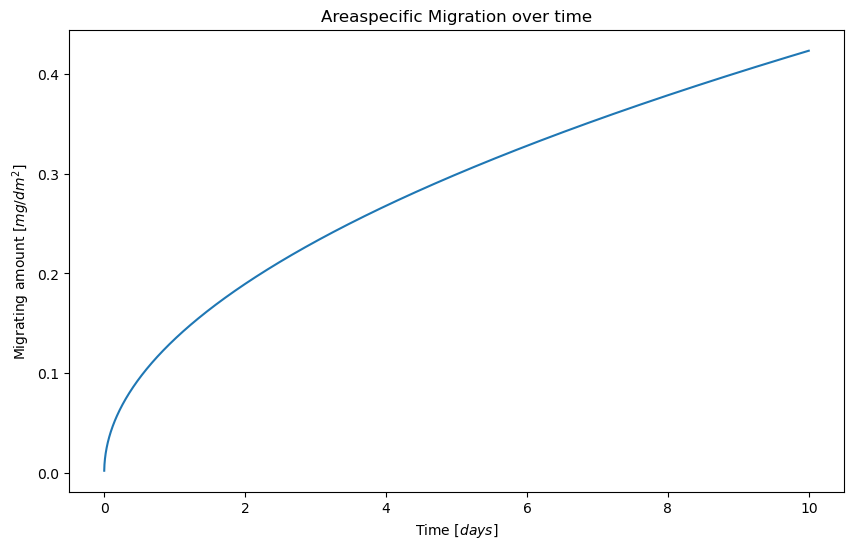

In [38]:
plt.figure(figsize = (10, 6))
time_days = np.arange(0, max_time / (3600 * 24), timestep / (3600 * 24))
plt.plot(time_days, results_area)
plt.title("Areaspecific Migration over time")
plt.xlabel("Time $[days]$")
plt.ylabel("Migrating amount $[mg/dm^2]$")
plt.show()

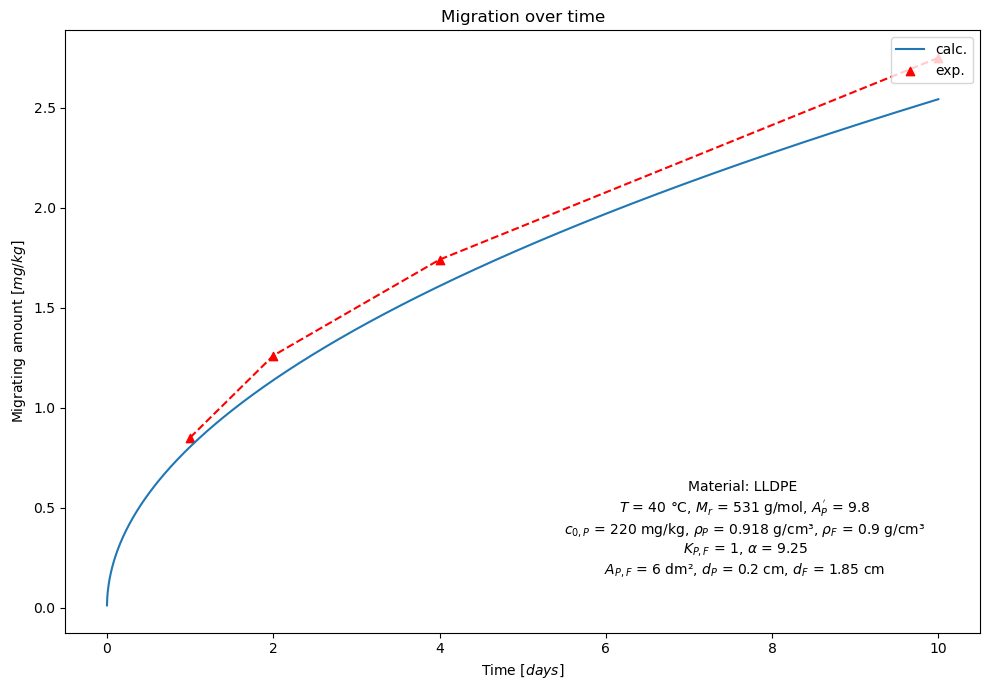

2.5424245304474313

In [39]:
plt.figure(figsize = (10, 7))
time_days = np.arange(0, max_time / (3600 * 24), timestep / (3600 * 24))
plt.plot(time_days, results, label = "calc.")

# Vergelich mit experimentellen Werten

t_exp_2 = [1, 2, 4, 10]
m_F_exp_2 = [0.85, 1.26, 1.74, 2.75]

# t_exp_3 = [4, 10, 20]
# m_F_exp_3 = [3.84, 6.06, 8.7]

plt.scatter(t_exp_2, m_F_exp_2, color = "red", marker= '^', label= "exp.")
plt.plot(t_exp_2, m_F_exp_2, color="red", linestyle='--')

plt.title("Migration over time")
plt.xlabel("Time $[days]$")
plt.ylabel("Migrating amount $[mg/kg]$")
plt.legend(loc="upper right")

# Unterschrift mit den Randbedingungen
conditions_text = (
    f"Material: {Material} \n"
    f"$T$ = {T_C} °C, $M_{{r}}$ = {M_mw} g/mol, $A_{{P}}^{{'}}$ = {A_Pt} \n"
    f"$c_{{0,P}}$ = {c_P0} mg/kg, $\\rho_{{P}}$ = {P_density} g/cm³, $\\rho_{{F}}$ = {F_density} g/cm³\n"
    f"$K_{{P,F}}$ = {K_PF}, $\\alpha$ = {alpha}\n"
    f"$A_{{P,F}}$ = {A_PF} dm², $d_{{P}}$ = {d_P} cm, $d_{{F}}$ = {d_F} cm\n"
)
# Füge den Text unterhalb des Plots hinzu
plt.figtext(0.75, 0.15, conditions_text, wrap=True, horizontalalignment='center', fontsize=10)

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()
results[-1]


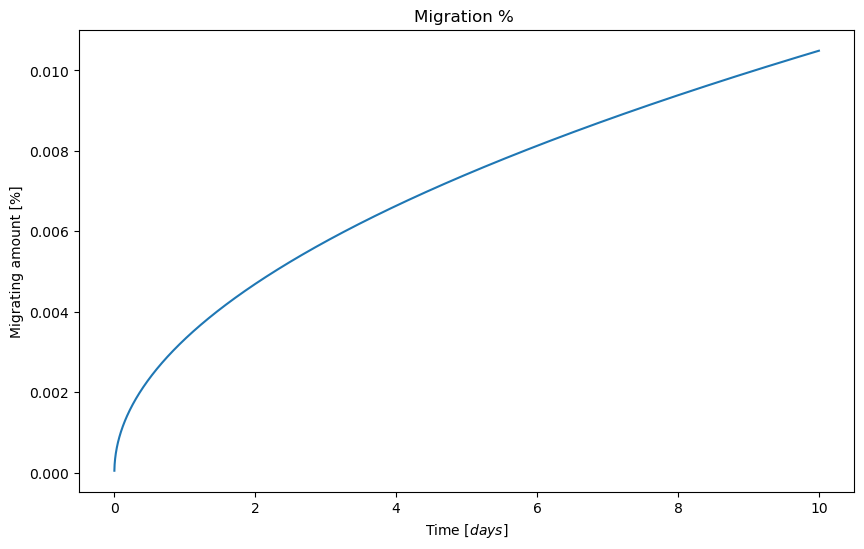

0.010490627395059382

In [40]:
plt.figure(figsize = (10, 6))
time_days = np.arange(0, max_time / (3600 * 24), timestep / (3600 * 24))
plt.plot(time_days, results_percent)
plt.title("Migration % ")
plt.xlabel("Time $[days]$")
plt.ylabel("Migrating amount [%]")
plt.show()
results_percent[-1]